In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from utils.helpers import *
from utils.preprocessing import *
from implementations.least_squares import least_squares
from implementations.ridge_regression import ridge_regression
import datetime
from implementations.costs import compute_loss
from utils.plots import *
%load_ext autoreload
%autoreload 2

In [2]:
y_train, tx_train, ids_train = load_csv_data('data/train.csv')
y_test, tx_test, ids_test = load_csv_data('data/test.csv')

In [3]:
x_train_sep, y_train_sep, ids_train_sep, indx_train_sep = split_data_by_DER_mass_MMC(tx_train, y_train, ids_train)
x_test_sep, y_test_sep, ids_test_sep, indx_test_sep = split_data_by_DER_mass_MMC(tx_test, y_test, ids_test)

In [16]:
from implementations.costs import compute_loss
from implementations.ridge_regression import ridge_regression
from implementations.least_squares import least_squares

def cross_validation(x, y, lambdas, poly_degree=-1, norm=None, method="ridge", n_splits=10, visualize=True, seed=0):
    rmse_tr = []
    rmse_te = []
    acc_tr = []
    acc_te = []
    
    for t, lambda_ in enumerate(lambdas):
        rmse_tr_t = []
        rmse_te_t = []
        acc_tr_t = []
        acc_te_t = []
        for train_ind, test_ind in k_fold_split(y=y, x=x, n_splits=n_splits, seed=seed):
            x_train_kfold = x[train_ind].copy()
            y_train_kfold = y[train_ind]
            x_test_kfold = x[test_ind].copy()
            y_test_kfold = y[test_ind]
            
            if norm == "min_max":
                x_train_kfold, x_test_kfold = min_max_normalization(x_train_kfold, x_test_kfold)
            elif norm == "std":
                x_test_kfold, x_test_kfold = standardize(x_train_kfold, x_test_kfold)
                
            x_train_kfold = build_poly(x_train_kfold, poly_degree)
            x_test_kfold = build_poly(x_test_kfold, poly_degree)
            
            if method == "ridge":
                w = ridge_regression(tx=x_train_kfold, y=y_train_kfold, lamb=lambda_)
            #elif: TO ADD NEW METHODS
            
            loss_tr = np.sqrt(2*compute_loss(y_train_kfold, x_train_kfold, w))
            loss_te = np.sqrt(2*compute_loss(y_test_kfold, x_test_kfold, w))
            rmse_tr_t.append(loss_tr)
            rmse_te_t.append(loss_te)
            
            train_pred = predict_labels(w, x_train_kfold)
            acc_tr_t.append(np.sum(y_train_kfold == train_pred)*1.0/len(train_pred))
            test_pred = predict_labels(w, x_test_kfold)
            acc_te_t.append(np.sum(y_test_kfold == test_pred)*1.0/len(test_pred))
            
        rmse_tr.append(np.mean(rmse_tr_t))
        rmse_te.append(np.mean(rmse_te_t))
        acc_tr.append(np.mean(acc_tr_t))
        acc_te.append(np.mean(acc_te_t))
    
    if visualize:
        cross_validation_visualization(lambdas, rmse_tr, rmse_te)
    lambda_ind = np.argmin(rmse_te)
    return lambdas[lambda_ind], acc_tr[lambda_ind], acc_te[lambda_ind]

In [17]:
def train_and_get_predictions(X_train, Y_train, X_test, Y_test, Y_inds, best_lambdas, poly_degree=-1, norm=None, method="ridge", seed=0):
    predictions = np.ones(568238)
    train_accuracy = []
    for i, lambda_ in enumerate(best_lambdas):
        x_train = X_train[i].copy()
        y_train = Y_train[i]
        x_test = X_test[i].copy()
        y_test = Y_test[i]
        
        if norm == "min_max":
            x_train, x_test = min_max_normalization(x_train, x_test)
        elif norm == "std":
            x_train, x_test = standardize(x_train, x_test)
            
        x_train = build_poly(x_train, poly_degree)
        x_test = build_poly(x_test, poly_degree)
        
        if method == "ridge":
            w = ridge_regression(tx=x_train, y=y_train, lamb=lambda_)
        #elif: ADD NEW METHODS
        
        #loss_train = np.sqrt(2*compute_loss(y_train, x_train, w))
        #print(loss_train)
        train_pred = predict_labels(w, x_train)
        train_accuracy.append(np.sum(y_train == train_pred)*1.0/len(y_train))
        
        predictions[Y_inds[i]] = predict_labels(w, x_test)
    
    print(train_accuracy)
    print(np.mean(train_accuracy))
    return predictions

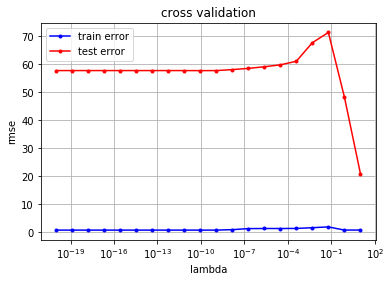

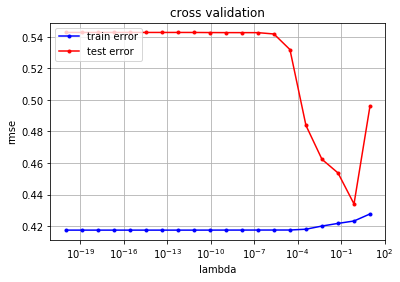

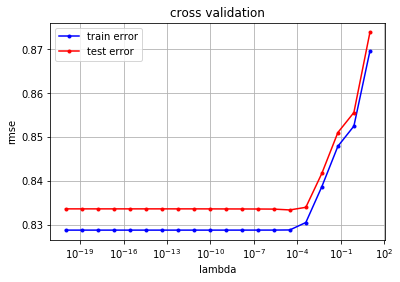

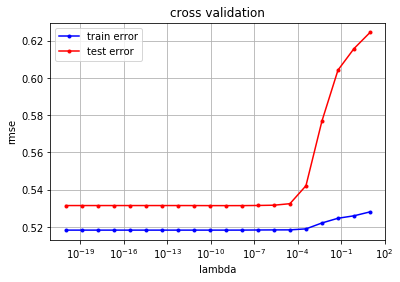

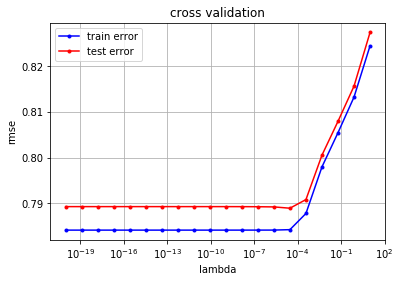

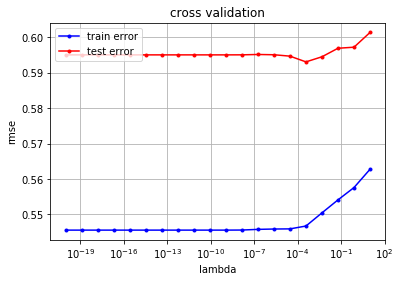

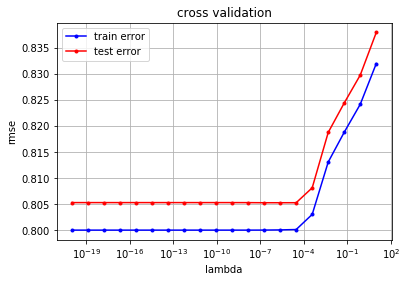

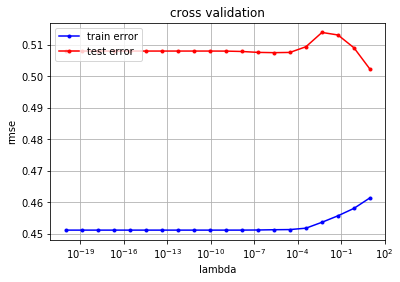

[10.0, 0.7847599703514623, 2.9763514416313253e-05, 1.128837891684693e-09, 2.9763514416313253e-05, 0.00037926901907322694, 1.8329807108324375e-07, 10.0]
0.8525165157346561
[0.7774856574964991, 0.9460694231750895, 0.7561334984598774, 0.9165931804820694, 0.7941656122592436, 0.9097551789077212, 0.7851601117558563, 0.9347694633408918]
0.8498921963210443
[0.7770158558070199, 0.9459035222052069, 0.7552872249214062, 0.915079365079365, 0.7931463517503163, 0.9030508474576271, 0.7831237911025145, 0.926530612244898]


In [20]:
number_of_models = 8

best_lambdas = []
acc_train = []
acc_test = []
for i in range(number_of_models):
    x_tr = x_train_sep[i]
    y_tr = y_train_sep[i]
    lambdas = np.logspace(-20, 1, 20)
    lambda_, acc_tr, acc_te = cross_validation(x_tr, y_tr, lambdas, poly_degree=3, norm=None)
    best_lambdas.append(lambda_)
    acc_train.append(acc_tr)
    acc_test.append(acc_te)
    
print(best_lambdas)
print(np.mean(acc_train))
print(acc_train)
print(np.mean(acc_test))
print(acc_test)

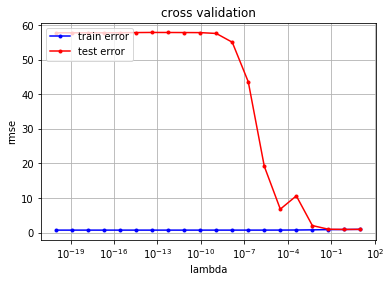

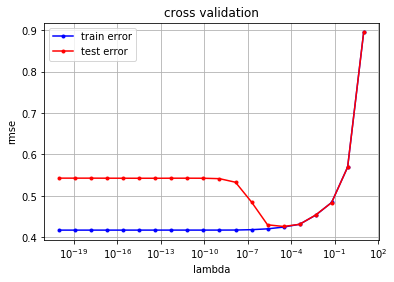

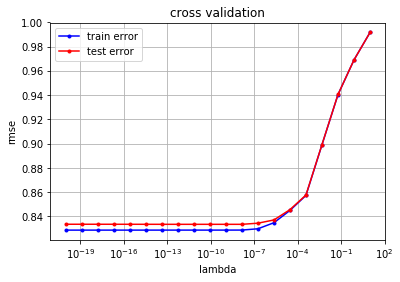

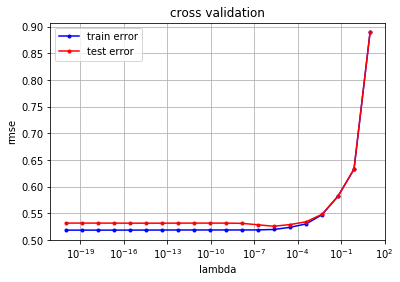

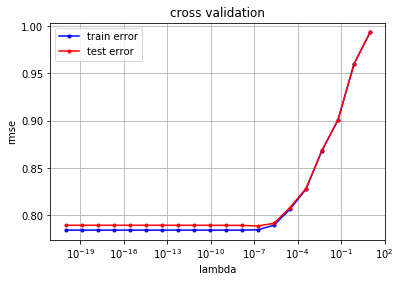

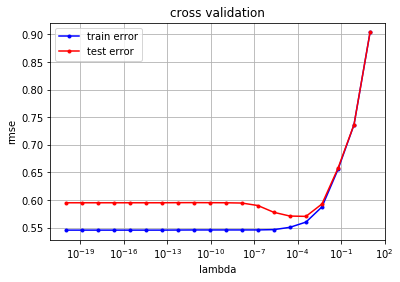

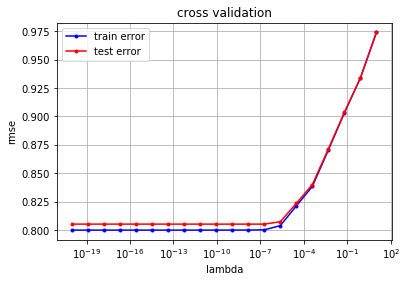

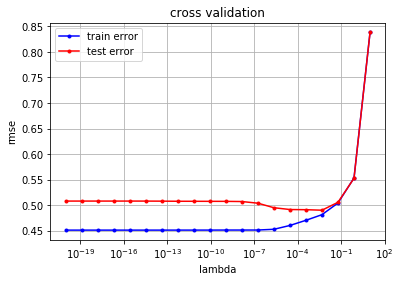

[0.7847599703514623, 2.9763514416313253e-05, 1.438449888287666e-08, 2.335721469090131e-06, 1.8329807108324375e-07, 0.00037926901907322694, 8.858667904100832e-11, 0.004832930238571772]
0.837741249691367
[0.67566065862583, 0.9446826612217116, 0.75641453113588, 0.9155496766607877, 0.7943085430432542, 0.8998116760828625, 0.7851923490221362, 0.9303099017384732]
0.8368455174632525
[0.67566065862583, 0.9446018376722819, 0.7556301800514433, 0.9149470899470898, 0.7934837621256854, 0.8972881355932204, 0.783220502901354, 0.9299319727891158]


In [21]:
number_of_models = 8

best_lambdas = []
acc_train = []
acc_test = []
for i in range(number_of_models):
    x_tr = x_train_sep[i]
    y_tr = y_train_sep[i]
    lambdas = np.logspace(-20, 1, 20)
    lambda_, acc_tr, acc_te = cross_validation(x_tr, y_tr, lambdas, poly_degree=3, norm="min_max")
    best_lambdas.append(lambda_)
    acc_train.append(acc_tr)
    acc_test.append(acc_te)
    
print(best_lambdas)
print(np.mean(acc_train))
print(acc_train)
print(np.mean(acc_test))
print(acc_test)

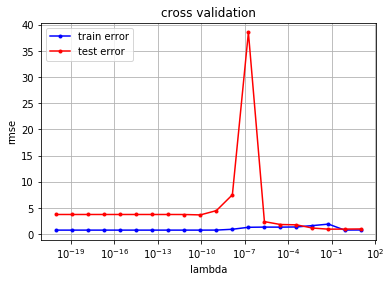

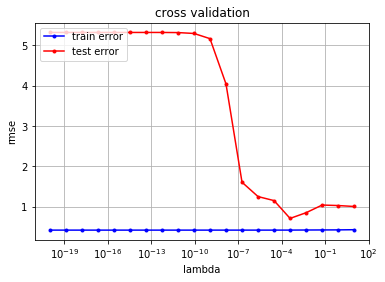

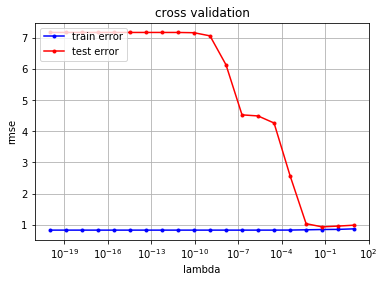

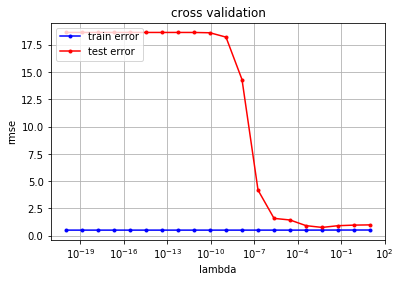

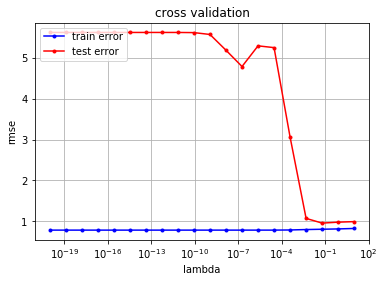

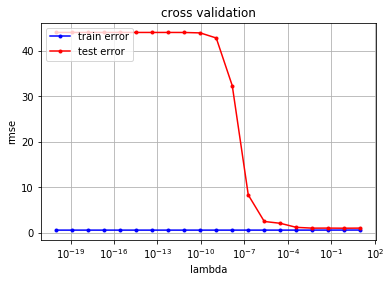

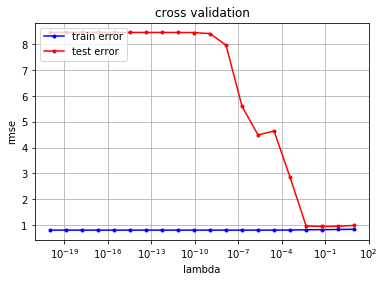

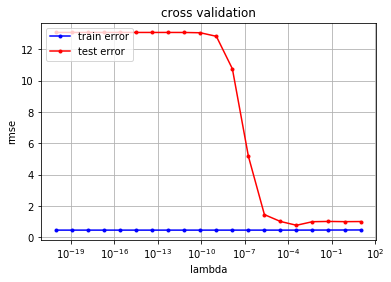

[0.061584821106602794, 0.00037926901907322694, 0.061584821106602794, 0.004832930238571772, 0.061584821106602794, 0.7847599703514623, 0.061584821106602794, 0.00037926901907322694]
0.8448303981509249
[0.7846094773456205, 0.9464650331801939, 0.7337413864278682, 0.9152851263962376, 0.7751792492619148, 0.9031261770244822, 0.763502041693531, 0.936734693877551]
0.7600431400360371
[0.6678682748339884, 0.9399310872894333, 0.6587453558159474, 0.9056878306878307, 0.6198228595529314, 0.7871186440677966, 0.6589941972920697, 0.8421768707482993]


In [22]:
number_of_models = 8

best_lambdas = []
acc_train = []
acc_test = []
for i in range(number_of_models):
    x_tr = x_train_sep[i]
    y_tr = y_train_sep[i]
    lambdas = np.logspace(-20, 1, 20)
    lambda_, acc_tr, acc_te = cross_validation(x_tr, y_tr, lambdas, poly_degree=3, norm="std")
    best_lambdas.append(lambda_)
    acc_train.append(acc_tr)
    acc_test.append(acc_te)
    
print(best_lambdas)
print(np.mean(acc_train))
print(acc_train)
print(np.mean(acc_test))
print(acc_test)

In [23]:
best_lambdas = [10.0, 0.7847599703514623, 2.9763514416313253e-05, 1.128837891684693e-09, 2.9763514416313253e-05, 0.00037926901907322694, 1.8329807108324375e-07, 10.0]

In [24]:
pred = train_and_get_predictions(x_train_sep, y_train_sep, x_test_sep, y_test_sep, indx_test_sep, best_lambdas)

[0.7632606044179429, 0.9401676683382459, 0.6732445485982109, 0.9100766992859032, 0.7181563244565332, 0.893970189701897, 0.7114613042007057, 0.9309410968178741]
0.8176598044771641


In [25]:
create_csv_submission(ids_test, pred, "output6.csv")